# Data Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

merged = pd.read_csv('final_merged_updated.csv')

merged.drop(columns={'Unnamed: 0'}, inplace=True)

merged['financialDate'] = pd.to_datetime(merged['financialDate'])

merged = merged.sort_values(by=['Supplier.Number','financialDate'])

# For each column in the DataFrame, create a new column with the immediate previous entry (grouped by Supplier.Number)
for col in merged.columns:
    new_col = 'prev_' + col
    merged[new_col] = merged.groupby('Supplier.Number')[col].shift(1)


# Remove rows where there's no previous Supplier.Number (i.e. first row per supplier)
merged = merged.loc[merged['prev_Supplier.Number'].notna()]

# Convert previous financialDate column to datetime and calculate difference in days
merged['prev_financialDate'] = pd.to_datetime(merged['prev_financialDate'])
merged['diff_days'] = (merged['financialDate'] - merged['prev_financialDate']).dt.days

# Calculate the difference in FHR
merged['diff_FHR'] = merged['FHR'] - merged['prev_FHR']

# Create a list of columns that start with 'prev_'
prev_cols = [col for col in merged.columns if col.startswith('prev_')]

# Add 'diff_days' and 'FHR' to that list
cols_to_keep = prev_cols + ['diff_days', 'FHR']

# Filter the DataFrame to keep only those columns
merged = merged[cols_to_keep]


merged.fillna(0, inplace=True)

merged.drop(columns={'prev_Supplier.Number', 'prev_Inflation.Rate....', 'prev_Parent.ID', 
                     'prev_id', 'prev_RRID', 'prev_Group', 'prev_period'}, inplace=True)

# save as CSV to use with modeling in the GitHub
merged.to_csv('final_previous_merged.csv', index=False)

To run a model to predict previous FHR, we needed to use our preprocessed dataset but groupby the supplier and shift it back to the previous time period. So each row in the new dataframe would consist of all of our features, including the previous FHR, and the current FHR (our y value). 

# Creating Currency EDA Plot

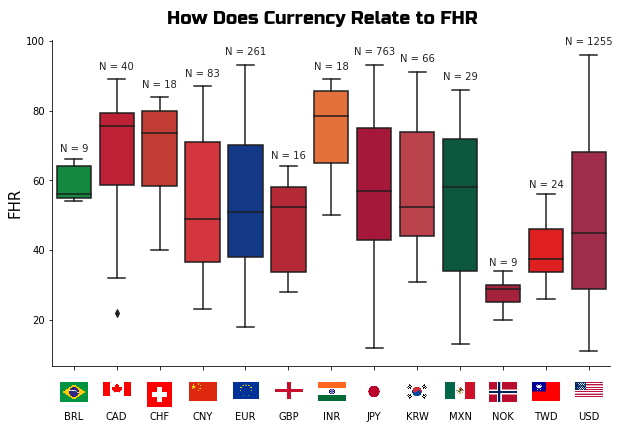

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from highlight_text import fig_text
from matplotlib.font_manager import FontProperties

# Load your data
merged = pd.read_csv('final_previous_merged.csv')

# Define the order of currencies (alphabetical order, or change as needed)
order = sorted(merged['prev_currency'].unique())

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#009b3a', '#D80621', '#DA291C', '#EE1C25', '#003399', '#CE1124', '#FF671F', 
          '#BC002D', '#CD2E3A', '#006341', '#BA0C2F', '#FE0000', '#B31942']

# Create the boxplot with the defined order
sns.boxplot(data=merged, x='prev_currency', y='FHR', ax=ax, order=order, palette=colors)

# Set axis labels
plt.xlabel("", fontsize=15)
plt.ylabel("FHR", fontsize=15)

# Set up a custom font for the title and add a custom title
font_path = 'C:/Users/Owner/Downloads/SoccermaticsForPython-master/SoccermaticsForPython-master/RussoOne-Regular.ttf'
title = FontProperties(fname=font_path)
fig_text(
    x=0.5, y=0.91, 
    s="How Does Currency Relate to FHR",
    va="bottom", ha="center",
    color="black", fontproperties=title, fontsize=18
)

# Get the x-axis tick positions; these correspond to the positions for 'order'
tick_positions = ax.get_xticks()

# Remove the default tick labels so we can add custom ones
ax.set_xticklabels([])

# Folder where flag images are stored (make sure filenames match, e.g., "USD.png")
flag_folder = "Flags"

# Loop over the currencies and add the corresponding flag and currency code
for pos, cat in zip(tick_positions, order):
    # Construct the file path for the flag image
    flag_path = os.path.join(flag_folder, f"{cat}.png")
    try:
        # Load the image and create an OffsetImage object (adjust zoom as needed)
        img = plt.imread(flag_path)
        im = OffsetImage(img, zoom=0.1)
        # Place the image at the appropriate x position and a fixed y position
        ab = AnnotationBbox(im, (pos, -0.05),
                            xycoords=('data', 'axes fraction'),
                            frameon=False,
                            box_alignment=(0.5, 1))
        ax.add_artist(ab)
    except FileNotFoundError:
        print(f"Flag image for {cat} not found at {flag_path}.")
    # Add the currency code text below the flag image using the x-axis transform
    ax.text(pos, -0.14, cat, transform=ax.get_xaxis_transform(), 
            ha='center', va='top', fontsize=10)

# Optionally, remove the top and right spines for a cleaner look
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Compute the count of rows for each currency
group_counts = merged.groupby('prev_currency').size()

# For each currency, determine a y-axis position slightly above its boxplot
for pos, cat in zip(tick_positions, order):
    count = group_counts.get(cat, 0)
    # Determine a y position: here we use the maximum FHR value for that currency and add an offset.
    max_val = merged[merged['prev_currency'] == cat]['FHR'].max()
    # The offset can be defined as a percentage of the max value (here, 5%)
    offset = 0.025 * max_val
    ax.text(pos, max_val + offset, f"N = {count}", ha='center', va='bottom', 
            fontsize=10, color='#222222')

plt.show()


From this plot, we can determine that country does indeed have an effect on FHR. However, it's effect can be hard to determine because of the limited sample size in certain areas, like Norway or Brazil. Despite this, there are still some notable trends such as Japanese and Canadian supplirs tending to have higher FHR ratings than Taiwanese and Amercian suppliers.

# Building the Baseline Model

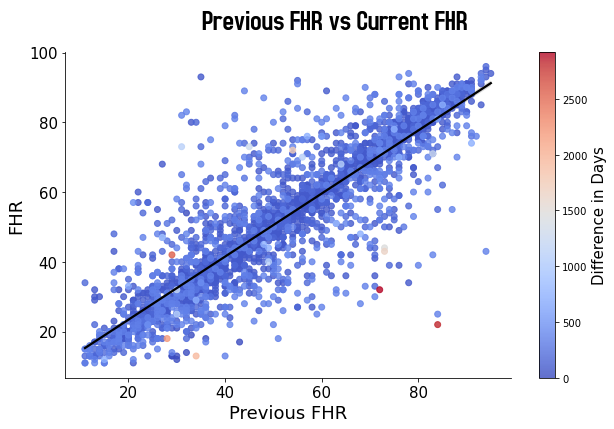

R-Squared 0.7642262824507922
Root Mean Squared Error: 10.312905894960466


In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from highlight_text import fig_text, ax_text
from matplotlib.font_manager import FontProperties



# loading font for plots
font_path = "C:/Users/Owner/Downloads/SoccermaticsForPython-master/SoccermaticsForPython-master/AccidentalPresidency.ttf"
belanosima = FontProperties(fname=font_path)

merged = pd.read_csv('final_previous_merged.csv')

plotting = merged.copy()

plotting.dropna(subset=['prev_FHR'], inplace=True)

plotting = plotting.sort_values(by='diff_days', ascending=True)


mean_prev_fhr = merged['prev_FHR'].mean()
mean_prev_chs = merged['prev_CHS'].mean()
mean_diff_days = merged['diff_days'].mean()

merged['prev_FHR'] = merged['prev_FHR'].fillna(mean_prev_fhr)
merged['prev_CHS'] = merged['prev_CHS'].fillna(mean_prev_chs)
merged['diff_days'] = merged['diff_days'].fillna(mean_diff_days)


merged['diff_days_category'] = np.where(merged['diff_days'] > 365, 1, 0)

above_1000 = len(merged.loc[merged['diff_days_category'] == 1])

below_1000 = len(merged.loc[merged['diff_days_category'] == 0])

merged_box = merged[['FHR', 'prev_FHR', 'diff_days_category']]

# Create the scatterplot
fig, ax = plt.subplots(figsize=(10, 6))
# Draw the regression line without scatter points
sns.regplot(
    x="prev_FHR", 
    y="FHR", 
    data=plotting, 
    scatter=False, 
    line_kws={'color': 'black'}
)

# Overlay the scatter plot with color mapping based on diff_days
sc = ax.scatter(
    plotting['prev_FHR'], 
    plotting['FHR'], 
    c=plotting['diff_days'], 
    cmap='coolwarm', 
    alpha=0.8
)

# Add labels, title, and grid
plt.xlabel("Previous FHR", fontsize=18)
plt.ylabel("FHR", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

fig_text(
    x = 0.5, y = .92, 
    s = "Previous FHR vs Current FHR",  # Use <> around the text to be styled
    va = "bottom", ha = "center",
    color = "black", fontproperties = belanosima, weight = "bold", size=30
)

cbar = plt.colorbar(sc)
cbar.set_label("Difference in Days", fontsize=15)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Display the plot
plt.show()

df_reg = plotting.dropna(subset=['prev_FHR'])

# Define the feature (previous FHR) and target (current FHR)
X = df_reg[['prev_FHR']]
y = df_reg['FHR']

# Optional: split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('R-Squared', r2)
print("Root Mean Squared Error:", rmse)


To start, we created a baseline model to predict the current FHR by solely using the previous FHR. For measuring the strength of our model we used the root mean squared error (RMSE) and r^2. The RMSE states how far off our models that predict FHR typically are from the actual FHR. R^2 is a statistic that measures the percentage of variability in FHR captured by our model. These metrics tell us that our baseline model does a good job of predicting current FHR by just using previous FHR. Our goal for the rest of the project is to beat this model.